# Moment Estimation of transcriptional parameters

From Bagnall et al. 2020



$$
\begin{align}
   b_m &= \frac{\sigma^2}{\mu} \\\
   \\\
    b_k &= \frac{k_{tc}}{k_{off}} \\\
   \\\
   f_m &= \frac{\mu}{b_m-1} \\\
   \\\
   f_k &= \frac{2k_{on}k_{off}}{\frac{k_{on}+k_{off}}{k_{d}}} \\\
   \\\\
   \mu &=  \frac{2k_{on}k_{tc}}{k_d(k_{on}+k_{off})} \\\
   \\\\
   \sigma^2 &=   \frac{\mu^2}{2}\frac{k_{off}}{k_{on}(1+\frac{k_{on}+k_{off}}{k_d})} \\\
\end{align}    
$$



In [346]:
ENV["Code"] = "../../Code"
for folder in readdir(ENV["Code"]); push!(LOAD_PATH, normpath(ENV["Code"], folder));end
include(ENV["Code"]*"/../Code_Paper/Code/meanmRNAcounts_BSBF.jl")
using Random, Statistics
using RCall

function bootstrap_mean_std(genedata, gene; cellssubsampled = 50, times = 1000, limit = 2)
    col = :Sample_Rep
    if !in( "N_exon",names(genedata))
        genedata[!,"N_exon"] = genedata[!,:TSS1_r2].+ genedata[!,:TSS2_r2] .+ genedata[!,:N_thres_Total]
    end
    new_df = DataFrames.DataFrame()
    genedata[!,:Sample] = genedata[!,:Genotype] .* "_" .* string.(genedata[!,:Timepoint])
    genedata[!,:Sample_Rep] = genedata[!,:Sample] .* "_" .* string.(genedata[!,:Rep])
    samples = unique(genedata[!,col])
    new_df[!,:Sample_Rep] = samples
    new_df[!,:Genotype] = [split(ii, "_")[1] for ii in samples]
    new_df[!,:Timepoint] = [split(ii, "_")[2] for ii in samples]
    new_df[!,:Rep] = [split(ii, "_")[3] for ii in samples]
    new_df[!,:Sample] = new_df[!,:Genotype] .* "_" .* new_df[!,:Timepoint]
    
    spt = split_by(genedata, col)
    means = []
    stds = []
    means_ = []
    stds_ = []
    bs = []
    bf = []
    
    
    
    for ii in samples
        distribution = spt[ii][!,:N_exon]
        n = length(distribution)
        subdist  = [distribution[shuffle(1:n)[1:cellssubsampled]] for jj in 1:times]
        push!(means, Statistics.mean([Statistics.mean(jj) for jj in subdist]))
        push!(stds, Statistics.mean([Statistics.std(jj) for jj in subdist]))
        push!(means_, Statistics.mean(distribution))
        push!(stds_, Statistics.std(distribution))
        distribution = append!(spt[ii][!,:TSS1_r2], spt[ii][!,:TSS2_r2])
        
        push!(bs, Statistics.mean(distribution[distribution.>limit]))
        push!(bf, Statistics.mean(distribution.>limit))
        
        
        
    end
    new_df[!,:Gene] = [gene for ii in means_]
    new_df[!,:mean] = means_
    new_df[!,:bootstrap_mean] = means
    new_df[!,:std] = stds_
    new_df[!,:bootstrap_std] = stds
    new_df[!,"TSS BS"] =  bs
    new_df[!,"momment BS"] =  (new_df[!,"bootstrap_std"].^2)./ new_df[!,"bootstrap_mean"]
    new_df[!,"TSS BF"] =  bf
    new_df[!,"momment BF"] = new_df[!,"bootstrap_mean"] ./ ( new_df[!,"bootstrap_std"].-1)
    
    new_df
    
end



ifnb1 = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*"CompleteSets/Ifnb1_mature.csv", DataFrames.DataFrame)
bf_ifnb1 = bootstrap_mean_std(ifnb1, "Ifnb1")
bf_ifnb1 = bf_ifnb1[parse.(Int, bf_ifnb1[!,:Timepoint]).==90, :]


il12b = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*"CompleteSets/Il12b_mature_nascent.csv", DataFrames.DataFrame)
bf_il12b = bootstrap_mean_std(il12b, "Il12b")
bf_il12b = bf_il12b[parse.(Int, bf_il12b[!,:Timepoint]).==90, :]
                
Cxcl10 = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*"CompleteSets/Cxcl10_mature.csv", DataFrames.DataFrame)
bf_Cxcl10 = bootstrap_mean_std(Cxcl10, "Cxcl10")
bf_Cxcl10 = bf_Cxcl10[bf_Cxcl10[!,:Timepoint].!=0, :]


ifit1 = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*"CompleteSets/Ifit1_mature.csv", DataFrames.DataFrame)
bf_ifit1 = bootstrap_mean_std(ifit1, "Ifit1")
bf_ifit1 = bf_ifit1[bf_ifit1[!,:Timepoint].=="180", :]

peli1 = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*"CompleteSets/Peli1_mature_nascent.csv", DataFrames.DataFrame)
bf_peli1 = bootstrap_mean_std(peli1, "Peli1")
bf_peli1 = bf_peli1[parse.(Int, bf_peli1[!,:Timepoint]).==90, :]


bfs = join_in_all_common_columns([bf_peli1, bf_il12b,bf_ifit1,bf_Cxcl10,bf_ifnb1])
bfs = bfs[bfs[!,:Genotype].=="WT", :]

,Sample_Rep,Genotype,Timepoint,Rep,Sample,Gene,mean,bootstrap_mean
,String,SubStri…,SubStri…,SubStri…,String,String,Any,Any
1,WT_90_1,WT,90,1,WT_90,Peli1,10.062,10.0936
2,WT_90_2,WT,90,2,WT_90,Peli1,37.3091,37.2188
3,WT_90_3,WT,90,3,WT_90,Peli1,8.86495,8.7853
4,WT_90_1,WT,90,1,WT_90,Il12b,4.84108,4.88066
5,WT_90_2,WT,90,2,WT_90,Il12b,25.1119,25.329
6,WT_90_3,WT,90,3,WT_90,Il12b,3.4976,3.48952
7,WT_90_4,WT,90,4,WT_90,Il12b,11.1096,11.1449
8,WT_180_1,WT,180,1,WT_180,Ifit1,59.6025,59.7049
9,WT_180_2,WT,180,2,WT_180,Ifit1,67.5858,67.5391


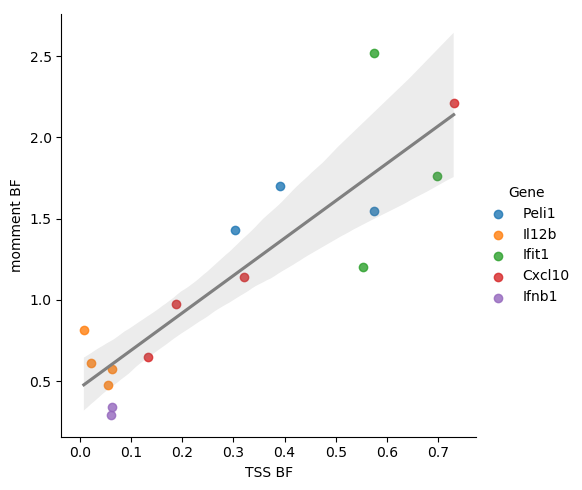

RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x and `#JL`$y
t = 7.0707, df = 14, p-value = 5.588e-06
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6908653 0.9592796
sample estimates:
      cor 
0.8838741 



In [347]:
Seaborn.lmplot(data = Pandas.DataFrame(bfs), x= "TSS BF", y = "momment BF", hue = "Gene",fit_reg = 0)
Seaborn.regplot(data = Pandas.DataFrame(bfs), x= "TSS BF", y = "momment BF", scatter = false, color = "gray")

x = [ii for ii in bfs[!,"TSS BF"]]
y = [ii for ii in bfs[!,"momment BF"]]
R"""cor.test($x, $y)"""

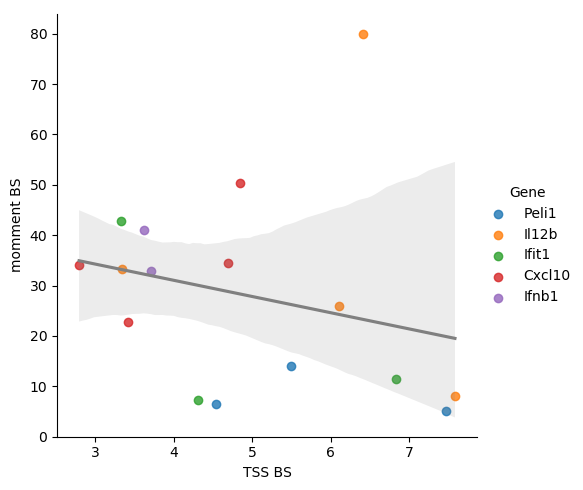

RObject{VecSxp}

	Pearson's product-moment correlation

data:  `#JL`$x and `#JL`$y
t = -0.96982, df = 14, p-value = 0.3486
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6640222  0.2795726
sample estimates:
       cor 
-0.2509045 



In [348]:
Seaborn.lmplot(data = Pandas.DataFrame(bfs), x= "TSS BS", y = "momment BS", hue = "Gene",fit_reg = 0)
Seaborn.regplot(data = Pandas.DataFrame(bfs), x= "TSS BS", y = "momment BS", scatter = false, color = "gray")
x = [ii for ii in bfs[!,"TSS BS"]]
y = [ii for ii in bfs[!,"momment BS"]]
R"""cor.test($x, $y)"""

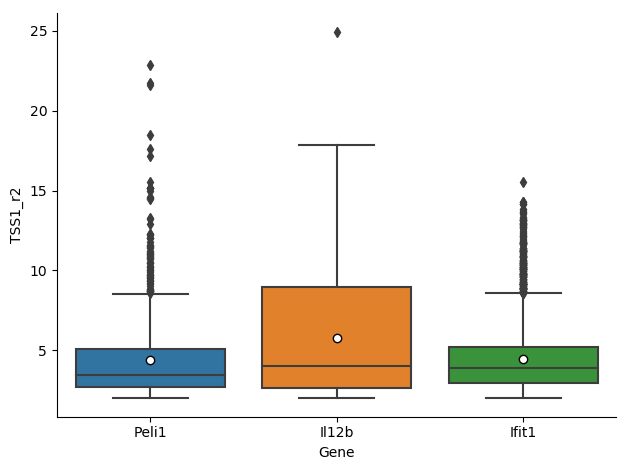

In [349]:
il12b_sub = tss_data(il12b[il12b[!,:Timepoint].==90, :], limit = 2); 
il12b_sub[!,:Gene] = ["Il12b" for ii in 1:nrow(il12b_sub)]

peli1_sub = tss_data(peli1[peli1[!,:Timepoint].==45, :], limit = 2); 
peli1_sub[!,:Gene] = ["Peli1" for ii in 1:nrow(peli1_sub)]
ifit1_sub = tss_data(ifit1[ifit1[!,:Timepoint].==180, :], limit = 2); 
ifit1_sub[!,:Gene] = ["Ifit1" for ii in 1:nrow(ifit1_sub)]


df = join_in_all_common_columns(peli1_sub, il12b_sub, ifit1_sub)


Seaborn.boxplot(data = Pandas.DataFrame(df), x= "Gene", y = "TSS1_r2", showmeans = true, 
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

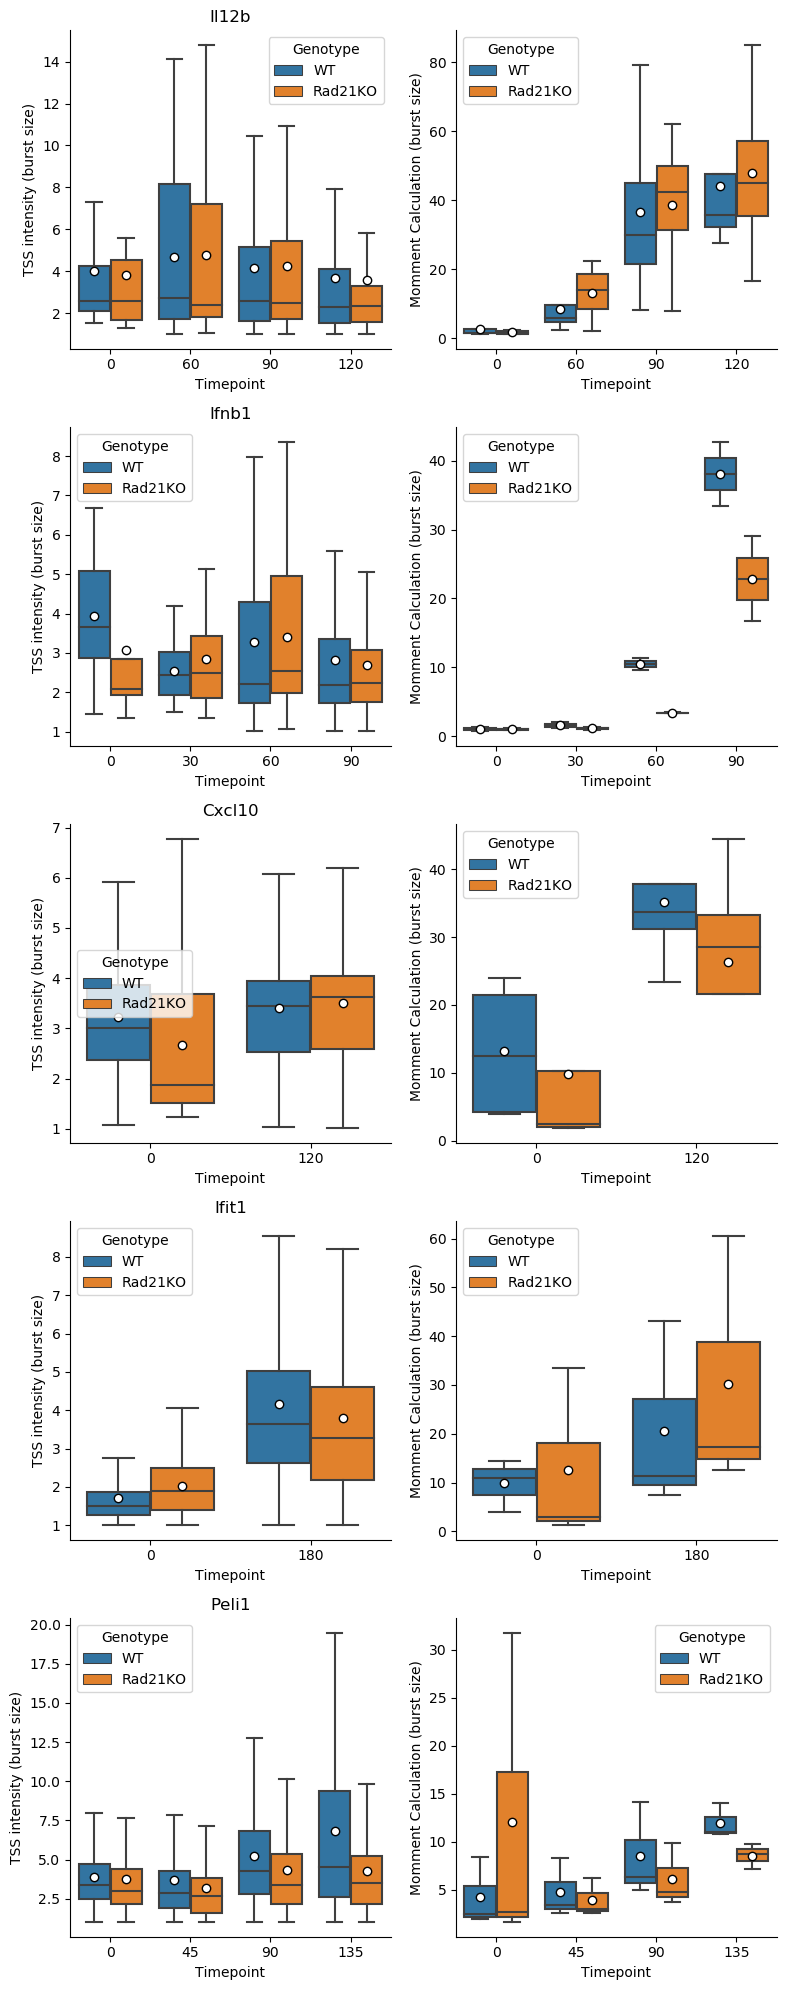

PyObject Text(423.125,0.5,'Momment Calculation (burst size)')

In [350]:
figure(figsize = (8, 20))


il12b_sub = tss_data(il12b, limit = 1); 

subplot(5,2,1)

Seaborn.boxplot(data = Pandas.DataFrame(il12b_sub), x= "Timepoint", y = "TSS1_r2", hue = "Genotype", showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

ylabel("TSS intensity (burst size)")
title("Il12b")


bf_il12b = bootstrap_mean_std(il12b, "Il12b")

subplot(5,2,2)
Seaborn.boxplot(data = Pandas.DataFrame(bf_il12b), x= "Timepoint", y = "momment BS", hue = "Genotype", showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

ylabel("Momment Calculation (burst size)")


ifnb1_sub = tss_data(ifnb1, limit = 1); 

subplot(5,2,3)

Seaborn.boxplot(data = Pandas.DataFrame(ifnb1_sub), x= "Timepoint", y = "TSS1_r2", hue = "Genotype", showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

ylabel("TSS intensity (burst size)")
title("Ifnb1")


bf_ifnb1 = bootstrap_mean_std(ifnb1, "ifnb1")

subplot(5,2,4)
Seaborn.boxplot(data = Pandas.DataFrame(bf_ifnb1), x= "Timepoint", y = "momment BS", hue = "Genotype", showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

ylabel("Momment Calculation (burst size)")



subplot(5,2,5)
Cxcl10_sub = tss_data(Cxcl10, limit = 1); 
Seaborn.boxplot(data = Pandas.DataFrame(Cxcl10_sub), x= "Timepoint", y = "TSS1_r2", hue = "Genotype", showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

ylabel("TSS intensity (burst size)")
title("Cxcl10")


bf_Cxcl10 = bootstrap_mean_std(Cxcl10, "Cxcl10")

subplot(5,2,6)
Seaborn.boxplot(data = Pandas.DataFrame(bf_Cxcl10), x= "Timepoint", y = "momment BS", hue = "Genotype", showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

ylabel("Momment Calculation (burst size)")


subplot(5,2,7)
ifit1_sub = tss_data(ifit1, limit = 1); 
Seaborn.boxplot(data = Pandas.DataFrame(ifit1_sub), x= "Timepoint", y = "TSS1_r2", hue = "Genotype", showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

ylabel("TSS intensity (burst size)")
title("Ifit1")


bf_ifit1 = bootstrap_mean_std(ifit1, "Ifit1")

subplot(5,2,8)
Seaborn.boxplot(data = Pandas.DataFrame(bf_ifit1), x= "Timepoint", y = "momment BS", hue = "Genotype", showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

ylabel("Momment Calculation (burst size)")


subplot(5,2,9)
peli1_sub = tss_data(peli1, limit = 1); 
Seaborn.boxplot(data = Pandas.DataFrame(peli1_sub), x= "Timepoint", y = "TSS1_r2", hue = "Genotype", showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

ylabel("TSS intensity (burst size)")
title("Peli1")


bf_peli1 = bootstrap_mean_std(peli1, "Peli1")

subplot(5,2,10)
Seaborn.boxplot(data = Pandas.DataFrame(bf_peli1), x= "Timepoint", y = "momment BS", hue = "Genotype", showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout()

ylabel("Momment Calculation (burst size)")

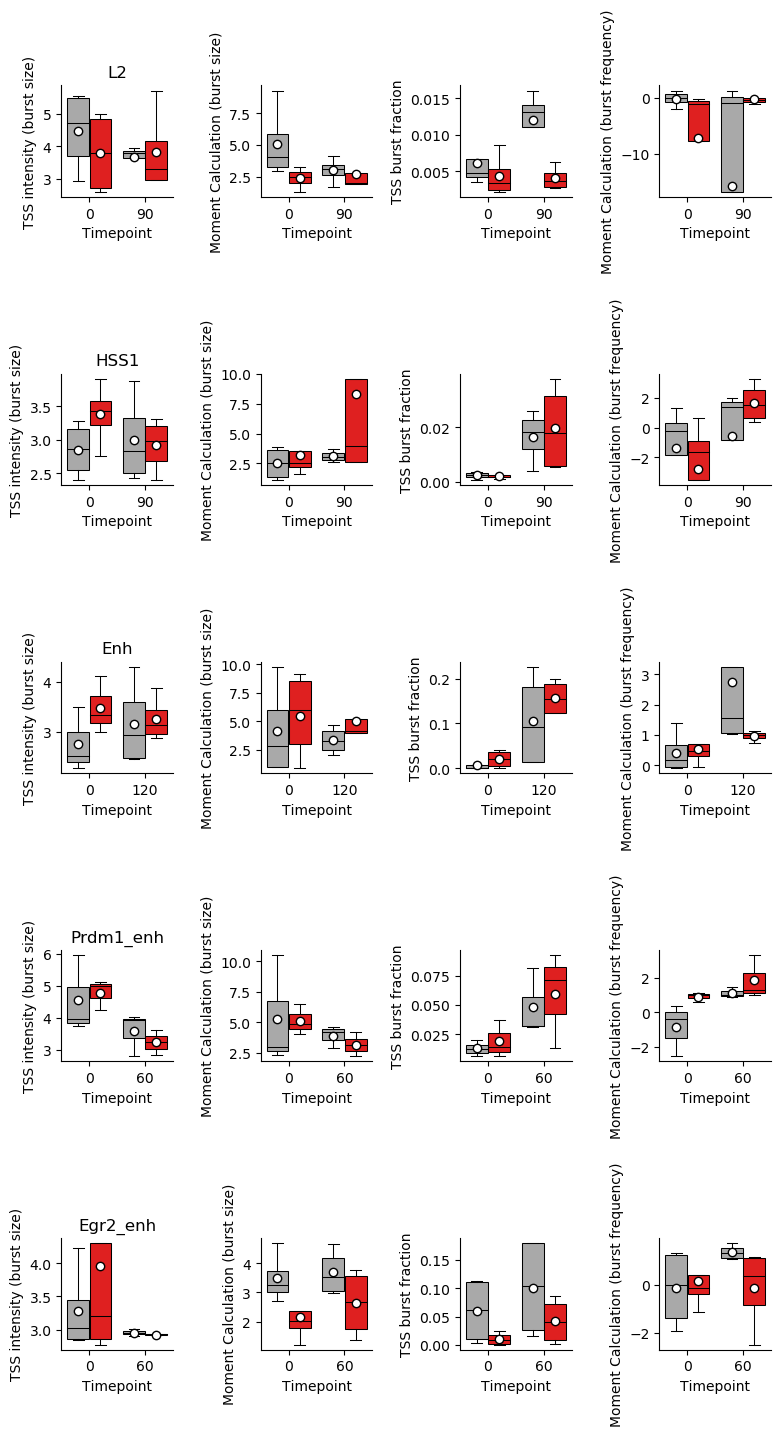

,Sample_Rep,Genotype,Timepoint,Rep,Sample,Gene,mean,bootstrap_mean
,String,SubStri…,SubStri…,SubStri…,String,String,Any,Any
1,WT_0_1,WT,0,1,WT_0,L2,0.33103,0.338809
2,WT_90_1,WT,90,1,WT_90,L2,0.229121,0.229994
3,WT_0_2,WT,0,2,WT_0,L2,0.133049,0.128588
4,WT_90_2,WT,90,2,WT_90,L2,0.141728,0.142743
5,Rad21KO_0_1,Rad21KO,0,1,Rad21KO_0,L2,0.42771,0.429039
6,Rad21KO_90_1,Rad21KO,90,1,Rad21KO_90,L2,0.206682,0.20801
7,Rad21KO_0_2,Rad21KO,0,2,Rad21KO_0,L2,0.135896,0.133424
8,Rad21KO_90_2,Rad21KO,90,2,Rad21KO_90,L2,0.277484,0.271972
9,WT_0_3,WT,0,3,WT_0,L2,0.234263,0.230699


In [381]:



function plot_probe_genedata(probe; c = 4, r = 4, n = 1, folder = "GeneData", lims = nothing)
    probe_df = CSV.read(ENV["Code"]*"/../Code_Paper/CompleteSets/"*folder*"/"*probe*".csv", DataFrames.DataFrame)
    if occursin("Prdm1", probe)
        probe_df = probe_df[probe_df[!,:Timepoint].!=30, :]
        probe_df = probe_df[probe_df[!,:Timepoint].!=90, :]
    end
    
    bf_probe = bootstrap_mean_std(probe_df, probe)
    subplot(c,r,c*(n-1)+1-(n-1))
    Seaborn.boxplot(data = Pandas.DataFrame(bf_probe), x= "Timepoint", y = "TSS BS", hue = "Genotype", 
             palette = Dict("WT"=>"darkgray", "Rad21KO" => "red"),
        showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"))
"""probe_sub = tss_data(probe_df, limit = 1); 
Seaborn.boxplot(data = Pandas.DataFrame(probe_sub), x= "Timepoint", y = "TSS1_r2", hue = "Genotype", 
        palette = Dict("WT"=>"darkgray", "Rad21KO" => "red"),
        showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"))"""
    pretty_axes2();plt.tight_layout(); squareplot(); legend_removal(), line075black()
    ylabel("TSS intensity (burst size)")
title(probe)
    
    subplot(c,r,c*(n-1)+2-(n-1))
Seaborn.boxplot(data = Pandas.DataFrame(bf_probe), x= "Timepoint", y = "momment BS", hue = "Genotype", 
             palette = Dict("WT"=>"darkgray", "Rad21KO" => "red"),
        showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout(); squareplot(); legend_removal(), line075black()

ylabel("Moment Calculation (burst size)")
    
        subplot(c,r,c*(n-1)+3-(n-1))
Seaborn.boxplot(data = Pandas.DataFrame(bf_probe), x= "Timepoint", y = "TSS BF", hue = "Genotype", 
             palette = Dict("WT"=>"darkgray", "Rad21KO" => "red"),
        showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout();squareplot(); legend_removal(), line075black()


ylabel("TSS burst fraction")
    
        subplot(c,r,c*(n-1)+4-(n-1))
Seaborn.boxplot(data = Pandas.DataFrame(bf_probe), x= "Timepoint", y = "momment BF", hue = "Genotype", 
             palette = Dict("WT"=>"darkgray", "Rad21KO" => "red"),
        showmeans = true, showfliers = false,
    meanprops = Dict("marker"=>"o", "markeredgecolor"=>"black", "markerfacecolor"=>"white"));pretty_axes2()
plt.tight_layout(); ylim(lims); squareplot();     legend_removal(), line075black()

ylabel("Moment Calculation (burst frequency)")
    
    return bf_probe

end

figure(figsize = (8, 15))
bfs = vcat(plot_probe_genedata("L2"; c = 5, r = 4, n = 1),
plot_probe_genedata("HSS1"; c = 5, r = 4, n = 2),
plot_probe_genedata("Enh"; c = 5, r = 4, n = 3),
plot_probe_genedata("Prdm1_enh"; c = 5, r = 4, n = 4),
plot_probe_genedata("Egr2_enh"; c = 5, r = 4, n = 5))

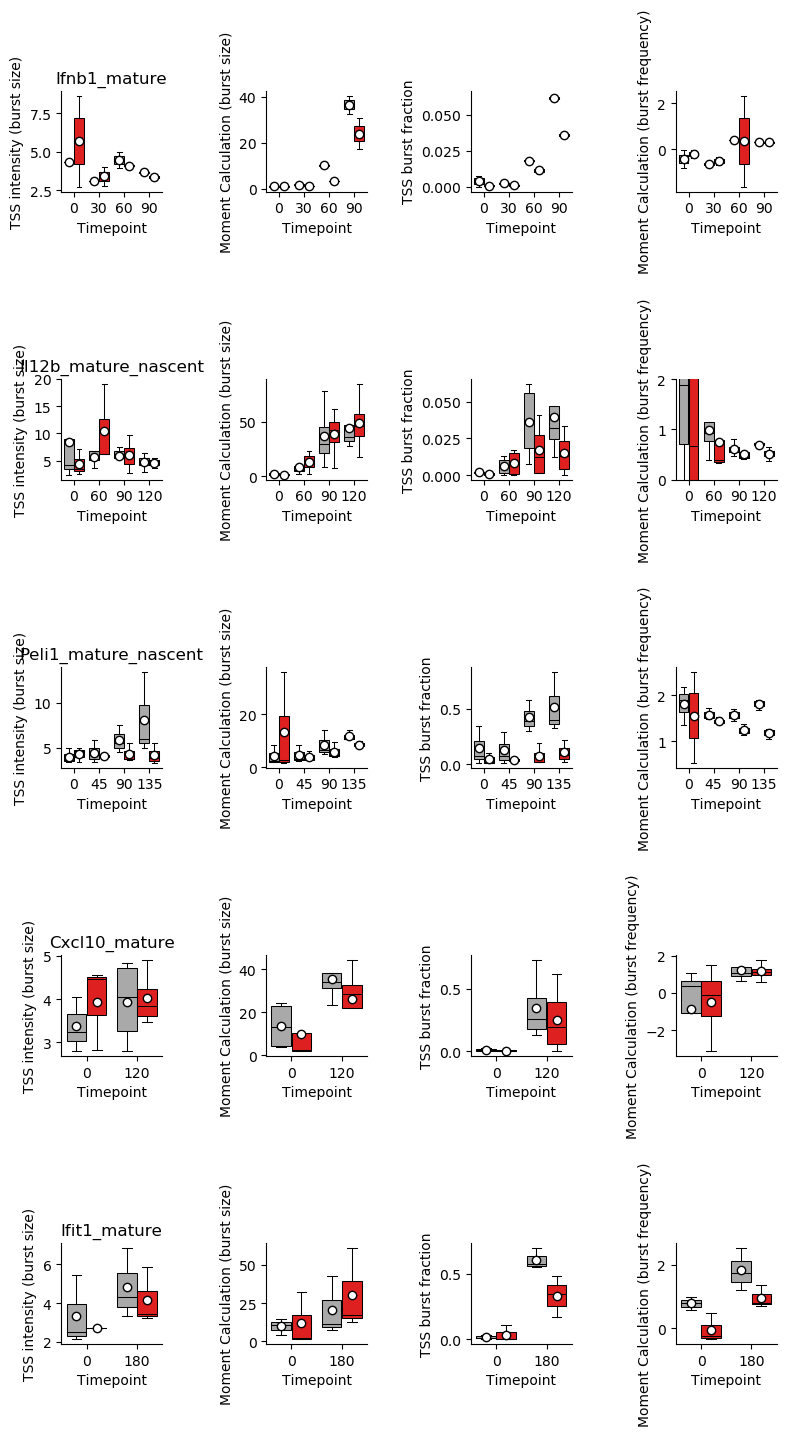

,Sample_Rep,Genotype,Timepoint,Rep,Sample,Gene
,String,SubStri…,SubStri…,SubStri…,String,String
1,WT_0_1,WT,0,1,WT_0,Ifnb1_mature
2,WT_30_1,WT,30,1,WT_30,Ifnb1_mature
3,WT_60_1,WT,60,1,WT_60,Ifnb1_mature
4,WT_90_1,WT,90,1,WT_90,Ifnb1_mature
5,Rad21KO_0_1,Rad21KO,0,1,Rad21KO_0,Ifnb1_mature
6,Rad21KO_30_1,Rad21KO,30,1,Rad21KO_30,Ifnb1_mature
7,Rad21KO_60_1,Rad21KO,60,1,Rad21KO_60,Ifnb1_mature
8,Rad21KO_90_1,Rad21KO,90,1,Rad21KO_90,Ifnb1_mature
9,WT_0_2,WT,0,2,WT_0,Ifnb1_mature


In [383]:

figure(figsize = (8, 15))
bfs = vcat(plot_probe_genedata("Ifnb1_mature"; c = 5, r = 4, n = 1, folder = "CompleteSets"),
plot_probe_genedata("Il12b_mature_nascent"; c = 5, r = 4, n = 2, folder = "CompleteSets", lims = (0, 2)),
plot_probe_genedata("Peli1_mature_nascent"; c = 5, r = 4, n = 3, folder = "CompleteSets"),
plot_probe_genedata("Cxcl10_mature"; c = 5, r = 4, n = 4, folder = "CompleteSets"),
plot_probe_genedata("Ifit1_mature"; c = 5, r = 4, n = 5, folder = "CompleteSets"))